# Kombinere tall fra to tabeller i Statistikkbanken i en tabell og en figur.
## Eksempel Konsumprisindeksen: KPI og KPI-JAE 

Kombinerer data fra Statistikkbanktabellene [03013](https://www.ssb.no/statbank/table/03013) og [05327](https://www.ssb.no/statbank/table/05327)
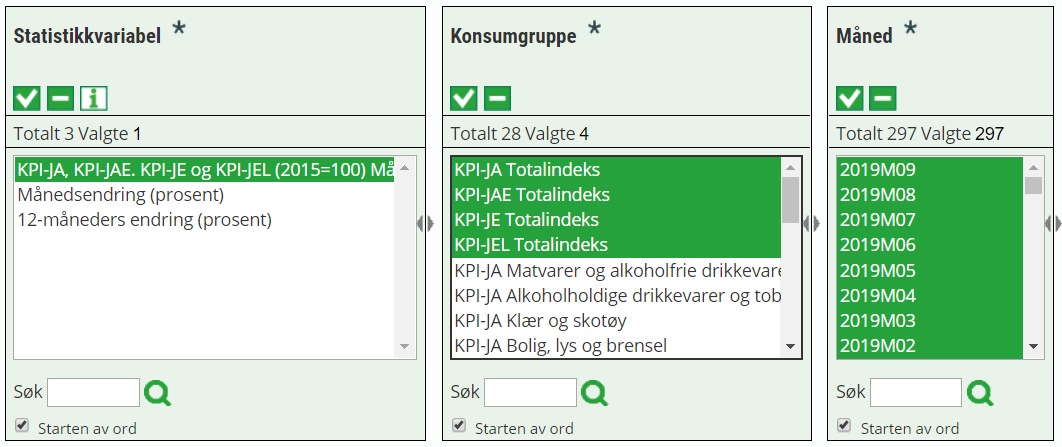

In [1]:
# Her importerer vi ulike pakker
%matplotlib inline
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pyjstat import pyjstat  # pyjstat er for behandling av JSON-stat

 Funksjon for å konvertere til datoformat og sette dette som en Pandas PeriodIndex, 
 Returnerer i tillegg navnet på frekvens-kolonnen

In [2]:

def dateConv(dataframe):
    frekvens, frek_no, frek_en, fmt = findFrequency(dataframe)
    setPeriodIndex(frekvens, frek_no, frek_en, fmt, dataframe)

    #funksjon for for å finne frekvenskolonne    
def findFrequency(dataframe):
    frekvenser = ['måned', 'kvartal', 'uke', 'år', 'year', 'quarter', 'month', 'week']
    frek_no = ''
    freq_en = ''
    fmt = ''
    for w in frekvenser:
        if w in dataframe.columns:
            if w in ['måned', 'month']:
                frek_no = 'M'
                frek_en = 'M'
                fmt = '%YM%m'
            elif w in ['kvartal', 'quarter']:
                frek_no = 'K'
                frek_en = 'Q'
                fmt = '%YK%q'
            elif w in ['uke', 'week']:
                frek_no = 'U';
                frek_en = 'W'
                fmt = '%YW%W-%w'
            else:
                frek_no = ''
                frek_en = 'A'
            return w, frek_no, frek_en, fmt
    
# funksjon for å sette index som PeriodIndex,       
def setPeriodIndex(frekvens, frek_no, freq_en, fmt, df):
    if frekvens in ['kvartal', 'quarter']:
        # erstatter K med Q, konverterr til datoformat og setter frekensen til Pandas PeriodIndex
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en), errors='coerce'), freq='Q-DEC')
    elif frekvens in ['uke', 'week']:
        df.index = pd.PeriodIndex(pd.to_datetime(df[frekvens].str.replace(frek_no, freq_en).add('-0'), format= fmt, errors='coerce'), freq='W-MON')
    else:
        df.index =  pd.PeriodIndex(pd.to_datetime(df[frekvens], format= fmt, errors='coerce'), freq=freq_en)
    return frekvens


URL til tabellenes metadata i PxWebApi, som vi skal poste spørringene mot

In [3]:
URL1 = 'https://data.ssb.no/api/v0/no/table/05327' # KPI-jae
URL2 = 'https://data.ssb.no/api/v0/no/table/03013' # KPI total

API-spørring i JSON mot tabell [05327](https://www.ssb.no/statbank/table/05327), data for siste 5 år (60 måneder)

In [4]:
sp1 = {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "item",
        "values": ['JA_TOTAL', 'JAE_TOTAL', 'JE_TOTAL', 'JEL_TOTAL']
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": ["KPIJustIndMnd"]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "top",
        "values": [ "60" ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


JSON-spørring mot tabell [03013](https://www.ssb.no/statbank/table/03013) siste 5 år

In [5]:
sp2 = {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "item",
        "values": ["TOTAL"]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": ["KpiIndMnd"]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "top",
        "values": ["60"]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


Poster spørringene sp1 og sp2 mot metadata url'er. Resultatene lagres som res1 og res2

In [6]:
res1 = requests.post(URL1, json=sp1)
res2 = requests.post(URL2, json=sp2)

Leser resultatet med JSON-stat biblioteket pyjstat

In [7]:
ds1 = pyjstat.Dataset.read(res1.text)
ds2 = pyjstat.Dataset.read(res2.text)

Skriver dette til to Pandas dataframes, df1 og df2.

In [8]:
df1 = ds1.write('dataframe')
df2 = ds2.write('dataframe')

In [9]:
df1.head(7)

,konsumgruppe,statistikkvariabel,måned,value
0,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M11,105.9
1,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M12,105.9
2,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2018M01,105.4
3,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2018M02,106.4
4,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2018M03,106.7
5,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2018M04,107.2
6,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2018M05,107.2


In [10]:
df1.tail() # slutten av datasettet

,konsumgruppe,statistikkvariabel,måned,value
235,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M06,118.9
236,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M07,120.6
237,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M08,119.6
238,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M09,120.9
239,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M10,121.4


Kaller funksjonen for datokonvertering. *Kan sløyfes*.

In [11]:
dateConv(df1)

In [12]:
df1.index

PeriodIndex(['2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04',
             '2018-05', '2018-06', '2018-07', '2018-08',
             ...
             '2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
             '2022-07', '2022-08', '2022-09', '2022-10'],
            dtype='period[M]', name='måned', length=240)

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 240 entries, 2017-11 to 2022-10
Freq: M
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   konsumgruppe        240 non-null    object 
 1   statistikkvariabel  240 non-null    object 
 2   måned               240 non-null    object 
 3   value               240 non-null    float64
dtypes: float64(1), object(3)
memory usage: 9.4+ KB


In [14]:
df1.tail(15)

,konsumgruppe,statistikkvariabel,måned,value
måned,,,,
2021-08,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2021M08,113.4
2021-09,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2021M09,113.8
2021-10,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2021M10,114.0
2021-11,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2021M11,114.1
2021-12,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2021M12,114.5
2022-01,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M01,114.3
2022-02,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M02,115.8
2022-03,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M03,116.5
2022-04,KPI-JEL Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2022M04,117.3


In [15]:
dateConv(df2) # kan sløyfes eller kommenteres ut.

Plot av df2 blir riktig, for her er det bare en serie

<AxesSubplot: xlabel='måned'>

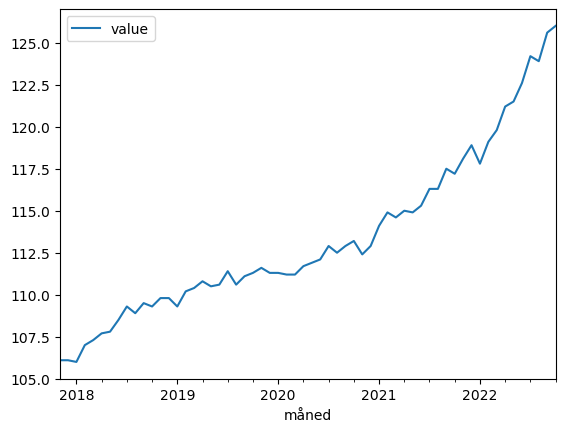

In [16]:
df2.plot()   

Standard plot av df1 gir alle 4 intervallene. Resultat er avhengig av om det er dato eller kategori på x-aksen.

<AxesSubplot: xlabel='måned'>

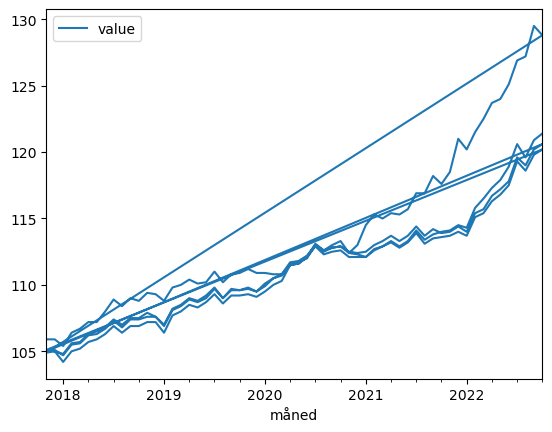

In [17]:
df1.plot() # standard plot gir alle 4 intervallene og resultat er avhengig av om det er dato eller kategori på x-aksen

### slår sammen de to "dataframene"  df1 og df2 med en enkel concat til datasettet "sammen"

In [18]:
sammen = pd.concat([df1,df2])

Viser topp og bunn for det sammeslåtte datasettet

In [19]:
sammen.head()

,konsumgruppe,statistikkvariabel,måned,value
måned,,,,
2017-11,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M11,105.9
2017-12,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2017M12,105.9
2018-01,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2018M01,105.4
2018-02,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2018M02,106.4
2018-03,KPI-JA Totalindeks,"KPI-JA, KPI-JAE. KPI-JE og KPI-JEL (2015=100) ...",2018M03,106.7


In [20]:
sammen.tail()

,konsumgruppe,statistikkvariabel,måned,value
måned,,,,
2022-06,Totalindeks,Konsumprisindeks (2015=100),2022M06,122.6
2022-07,Totalindeks,Konsumprisindeks (2015=100),2022M07,124.2
2022-08,Totalindeks,Konsumprisindeks (2015=100),2022M08,123.9
2022-09,Totalindeks,Konsumprisindeks (2015=100),2022M09,125.6
2022-10,Totalindeks,Konsumprisindeks (2015=100),2022M10,126.0


### Omstrukturerer (pivoterer) tabellen for å få en bedre visning

Se evt. ["Tidy data" av Hadley Wickham](https://vita.had.co.nz/papers/tidy-data.pdf)


In [21]:
df3 = sammen.pivot(columns='konsumgruppe', values='value')

# uten kall til dateconv() bruk måned som index slik
# df3 = sammen.pivot(index='måned', columns='konsumgruppe', values='value')

In [22]:
df3.head(3)

konsumgruppe,KPI-JA Totalindeks,KPI-JAE Totalindeks,KPI-JE Totalindeks,KPI-JEL Totalindeks,Totalindeks
måned,,,,,
2017-11,105.9,104.9,105.0,105.1,106.1
2017-12,105.9,105.0,105.1,105.0,106.1
2018-01,105.4,104.2,104.7,104.8,106.0


In [23]:
df3.index

PeriodIndex(['2017-11', '2017-12', '2018-01', '2018-02', '2018-03', '2018-04',
             '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10',
             '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04',
             '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10',
             '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04',
             '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10',
             '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04',
             '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10',
             '2021-11', '2021-12', '2022-01', '2022-02', '2022-03', '2022-04',
             '2022-05', '2022-06', '2022-07', '2022-08', '2022-09', '2022-10'],
            dtype='period[M]', name='måned')

In [24]:

df3.tail(3)

konsumgruppe,KPI-JA Totalindeks,KPI-JAE Totalindeks,KPI-JE Totalindeks,KPI-JEL Totalindeks,Totalindeks
måned,,,,,
2022-08,127.2,119.0,118.6,119.6,123.9
2022-09,129.5,120.2,119.8,120.9,125.6
2022-10,128.8,120.6,120.2,121.4,126.0


### Figur med Pandas innebygde plot-funksjon 

<AxesSubplot: xlabel='måned'>

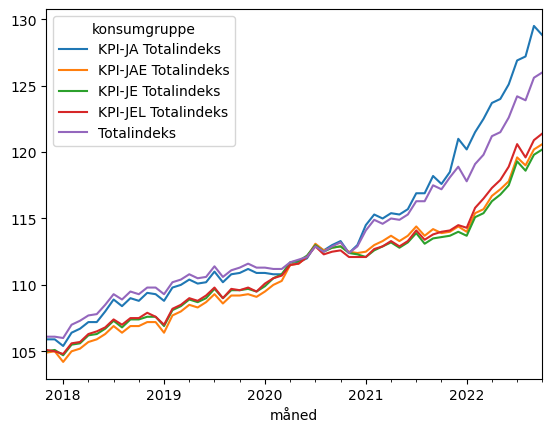

In [25]:
df3.plot()

Plot med flere parametre

<AxesSubplot: xlabel='måned'>

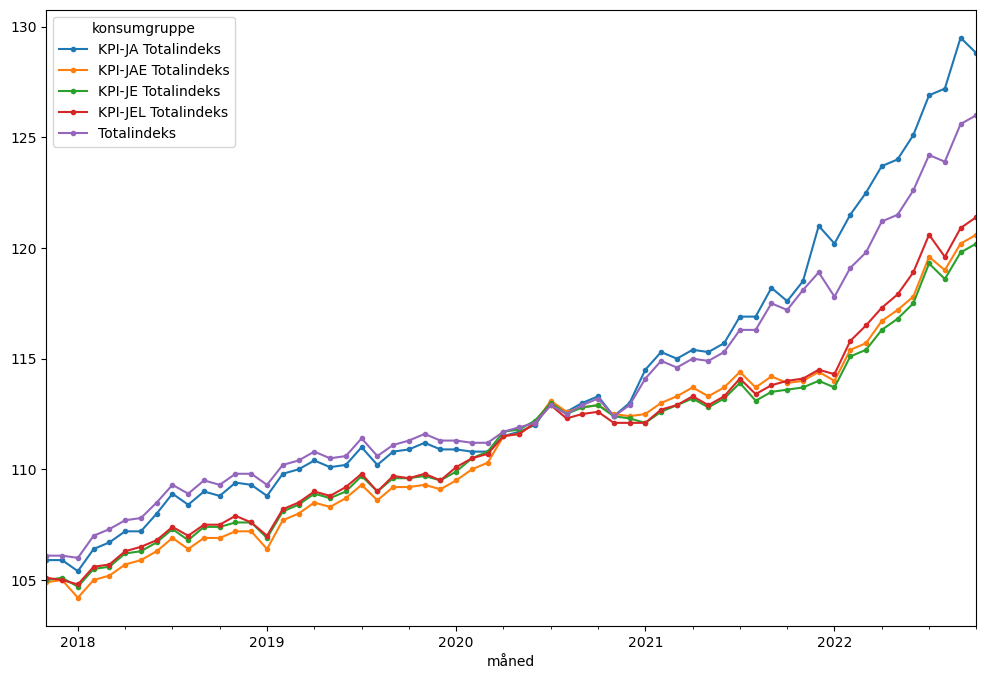

In [26]:
df3.plot(marker="o", markersize=3, figsize=(12, 8))

Lagrer figurvisningen som en funksjon. Her brukes det litt mer fleksible Matplotlib. Her er også SSBfarger definert. Du kan gi høyde og bredde som parametre.

In [27]:
def visfigur(bredde=12, hoyde=6):
    fig, ax = plt.subplots(figsize=(bredde, hoyde))  
    #definerer ssb farger på figurene
    ssbCol = ['#1a9d49', '#075745', '#1d9de2', '#0f2080', '#c78800', '#471f00', '#c775a7', '#a3136c', '#909090', '#000000']
    plt.xlabel('måned') 
    plt.ylabel('index')
    ax.set_title('Figur som viser KPI total og undeliggende KPI serier')
    df3.plot(ax=ax, color=ssbCol)
    plt.show()

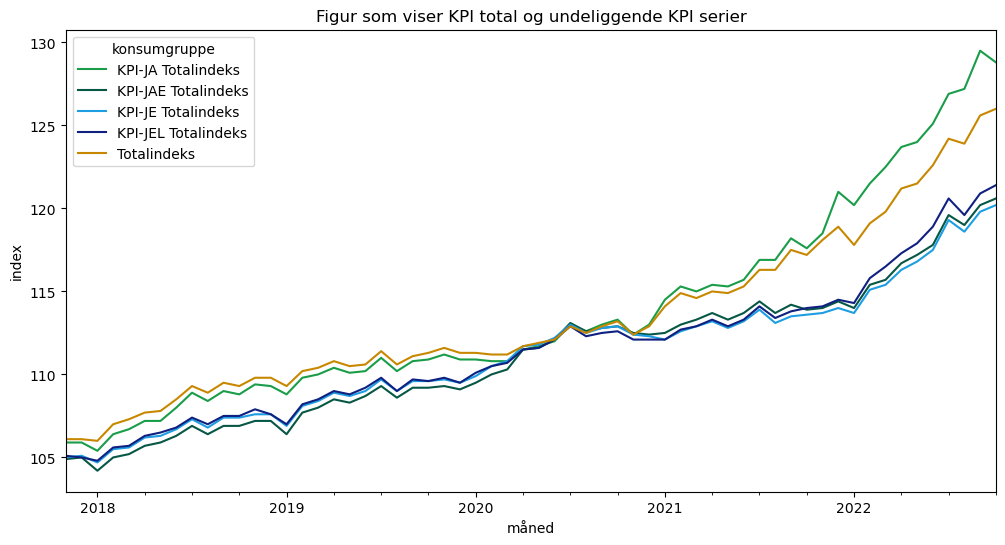

In [28]:
visfigur()

### Plot med ulike stiler
I Matplotlib kan du prøve ut ulike ferdige stiler. Vi kan evt. lage vår egen etter SSBs designmal.

Prøv ut: 'Solarize_Light2',  'bmh', 'classic', 'dark_background' 'fivethirtyeight', 'seaborn-talk'

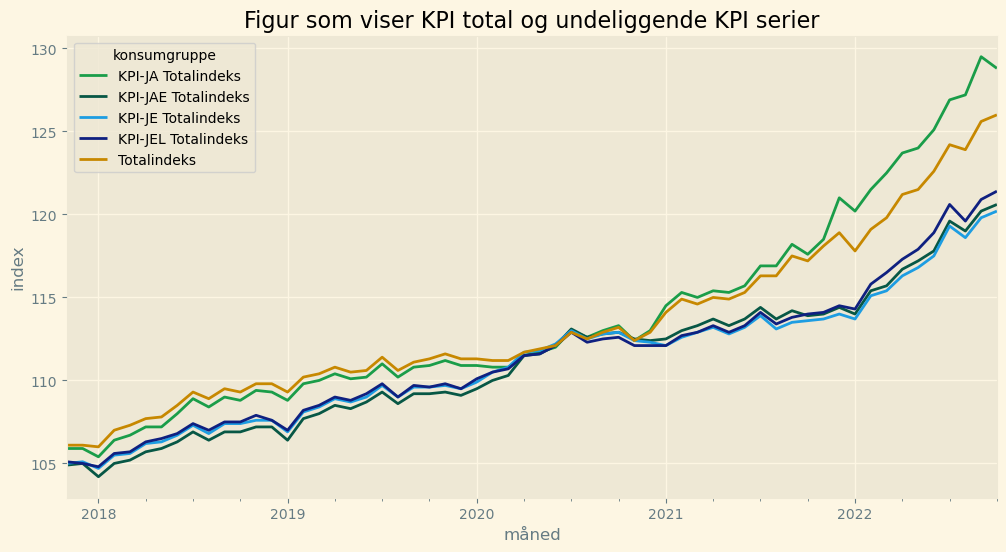

In [29]:
with plt.style.context('Solarize_Light2'):
    visfigur()

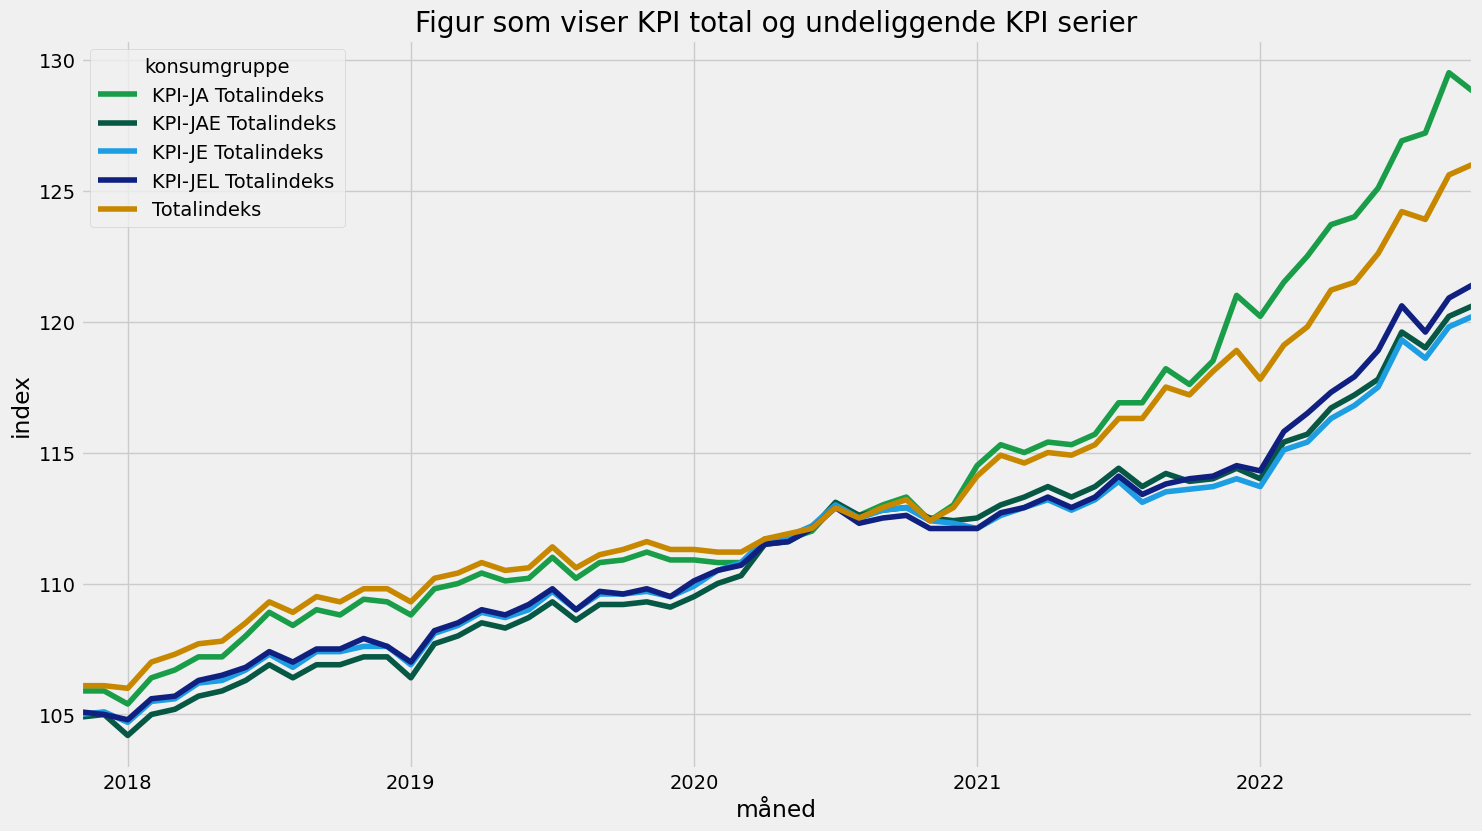

In [30]:
with plt.style.context('fivethirtyeight'):
    visfigur(16, 9)